"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

In [0]:
import gym
import torch
import matplotlib.pyplot as plt

In [0]:
env = gym.make("Taxi-v3")

#### Renders one frame of the environment

In [256]:
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [257]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


In [258]:
state = env.encode(3, 3, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 368
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [259]:
env.P[368]

{0: [(1.0, 468, -1, False)],
 1: [(1.0, 268, -1, False)],
 2: [(1.0, 388, -1, False)],
 3: [(1.0, 368, -1, False)],
 4: [(1.0, 368, -10, False)],
 5: [(1.0, 368, -10, False)]}

**Solving the environment without Reinforcement Learning**

In [260]:
env.reset()
#env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 200
Penalties incurred: 67


In [0]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.9)
        
print_frames(frames)

**Defining the Epsilon-Greedy behaviour**

In [0]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q):
          probs = torch.ones(n_action) * epsilon / n_action
          best_action = torch.argmax(Q[state]).item()
          probs[best_action] += 1.0 - epsilon
          action = torch.multinomial(probs, 1).item()
          return action
    return policy_function

#### 1. Specify number of episodes
#### 2. Initialize 2 variables tracking length and reward for each episode

In [0]:
n_episode = 100000
length_episode_SARSA = [0] * n_episode
total_reward_episode_SARSA = [0] * n_episode

In [0]:
from collections import defaultdict

def sarsa(env, gamma, n_episode, alpha):

     n_action = env.action_space.n
     Q = defaultdict(lambda: torch.zeros(n_action))
     frames =[]
     for episode in range(n_episode):
         state = env.reset()
         is_done = False
         action = epsilon_greedy_policy(state, Q)
         while not is_done:
             next_state, reward, is_done, info  = env.step(action)
                                   
             next_action = epsilon_greedy_policy(next_state, Q)
             td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
                                                
             Q[state][action] += alpha * td_delta
             length_episode_SARSA[episode] += 1
             total_reward_episode_SARSA[episode] += reward
             frames.append({
                      'frame': env.render(mode='ansi'),
                      'state': state,
                      'action': action,
                      'reward': reward
                            }
                            )
             if is_done:
                 break
             state = next_state
             action = next_action
     policy = {}
     for state, actions in Q.items():
         policy[state] = torch.argmax(actions).item()
     return Q, policy,frames

#### Setting default hyperparameters for now 

In [0]:
gamma = 1
alpha = 0.4
epsilon = 0.1

#### Call on Epsilon-Greedy function to create an instance of the policy

In [0]:
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

#### Call on SARSA function with defined hyperparameters - returning Q-Function and Policy

In [417]:
%%time
optimal_Q, optimal_policy, frames = sarsa(env, gamma, n_episode, alpha)

CPU times: user 5min 13s, sys: 1.71 s, total: 5min 15s
Wall time: 5min 16s


#### Tracks the Length of each episode

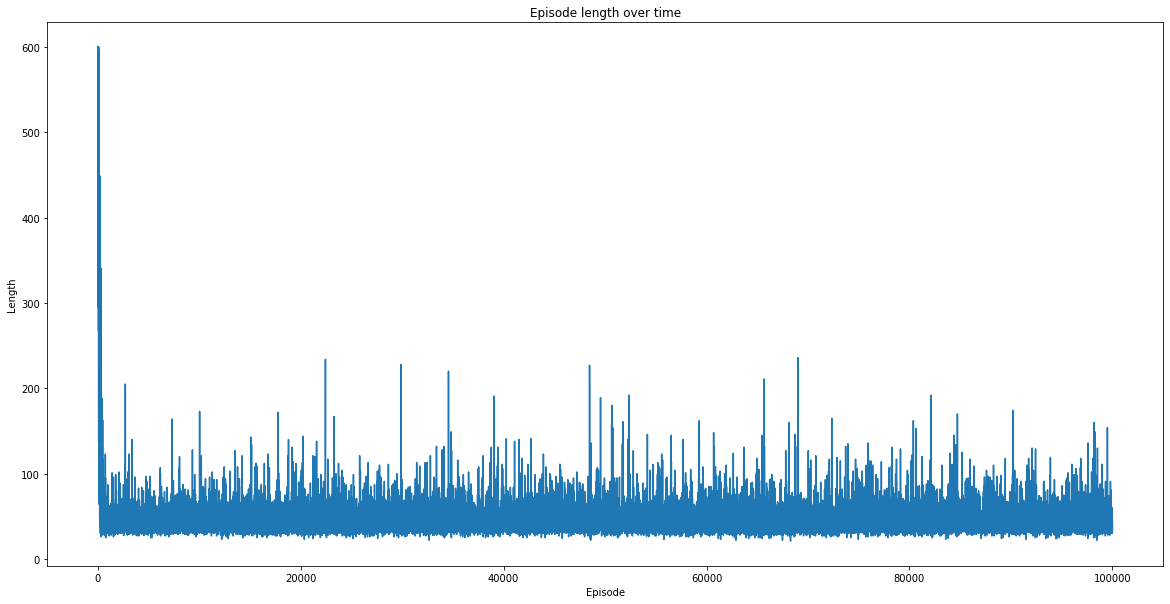

In [418]:
plt.figure(figsize=(20,10))
plt.plot(length_episode_SARSA)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

#### Tracks the Total Rewards of each episode

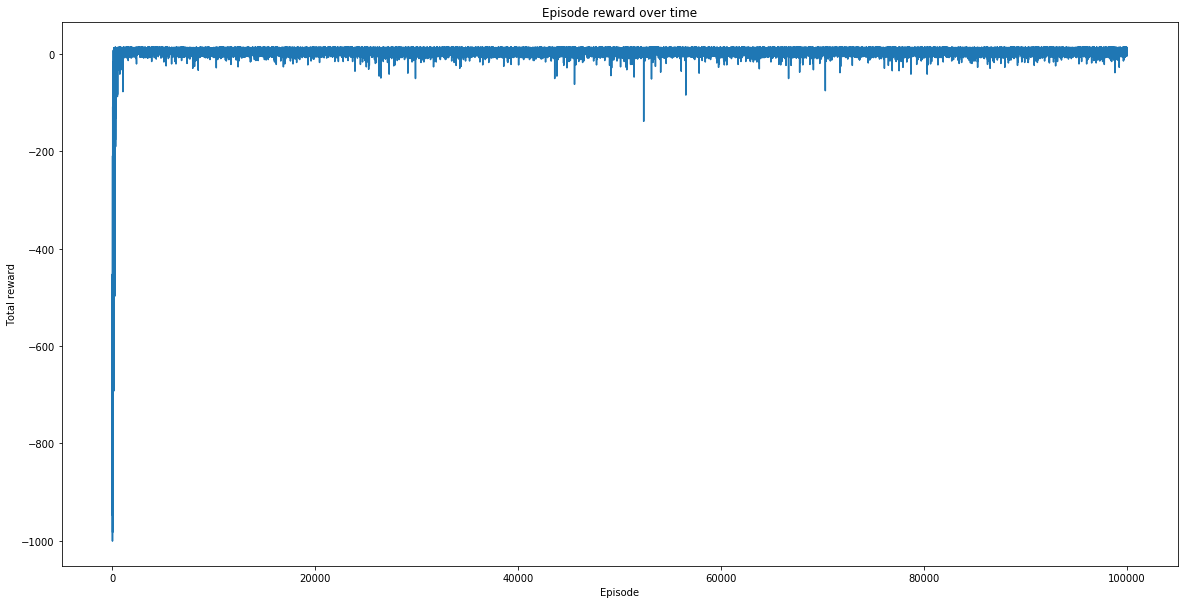

In [397]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_SARSA)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

### HYPERPARAMETER TUNING

#### Set intial candidates for each of the hyperparameters listen

In [0]:
alpha_options = [0.4, 0.5, 0.6]
epsilon_options = [0.3, 0.1, 0.01]
n_episode = 10000

In [168]:
for alpha in alpha_options:
     for epsilon in epsilon_options:
         length_episode = [0] * n_episode
         total_reward_episode = [0] * n_episode
         sarsa(env, gamma, n_episode, alpha)
         reward_per_step = [reward/float(step) for 
                            reward, step in zip(
                        total_reward_episode, length_episode)]
         print('alpha: {}, epsilon: {}'.format(alpha, epsilon))
         print('Average reward over {} episodes: {}'.format(
            n_episode, sum(total_reward_episode) / n_episode))
         print('Average length over {} episodes: {}'.format(
            n_episode, sum(length_episode) / n_episode))
         print('Average reward per step over {} episodes: {}\n'.format(
            n_episode, sum(reward_per_step) / n_episode))

alpha: 0.4, epsilon: 0.3
Average reward over 10000 episodes: 2.37
Average length over 10000 episodes: 16.0158
Average reward per step over 10000 episodes: 0.5729473818404908

alpha: 0.4, epsilon: 0.1
Average reward over 10000 episodes: 2.6414
Average length over 10000 episodes: 15.8788
Average reward per step over 10000 episodes: 0.5697488054476291

alpha: 0.4, epsilon: 0.01
Average reward over 10000 episodes: 2.7891
Average length over 10000 episodes: 15.7674
Average reward per step over 10000 episodes: 0.5824264228266844

alpha: 0.5, epsilon: 0.3
Average reward over 10000 episodes: 2.7574
Average length over 10000 episodes: 15.9197
Average reward per step over 10000 episodes: 0.5453765950708273

alpha: 0.5, epsilon: 0.1
Average reward over 10000 episodes: 1.8791
Average length over 10000 episodes: 16.6723
Average reward per step over 10000 episodes: 0.48852969838843463

alpha: 0.5, epsilon: 0.01
Average reward over 10000 episodes: 2.5957
Average length over 10000 episodes: 16.1333
Av

In [169]:
env.P[368]

{0: [(1.0, 468, -1, False)],
 1: [(1.0, 268, -1, False)],
 2: [(1.0, 388, -1, False)],
 3: [(1.0, 368, -1, False)],
 4: [(1.0, 368, -10, False)],
 5: [(1.0, 368, -10, False)]}

In [0]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [332]:
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

**Q- Learning**


In [411]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

q_table = np.zeros([env.observation_space.n, env.action_space.n])

n_episode = 100000
# Hyperparameters
alpha = 0.4
gamma = 1
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []
length_episode_Q = [0] * n_episode
total_reward_episode_Q = [0] * n_episode

for episode in range(n_episode):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1
        
        state = next_state
        length_episode_Q[episode] += 1
        total_reward_episode_Q[episode] += reward
        epochs += 1
        
    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode}")

print("Training finished.\n")

Episode: 99900
Training finished.

CPU times: user 57.8 s, sys: 7.81 s, total: 1min 5s
Wall time: 57.7 s


In [334]:
q_table

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.19800737, -5.6       , -5.43578293, -5.6       , 11.        ,
        -8.        ],
       [-2.55666176, -2.8       , -2.6692096 , -2.8       , 15.        ,
        -4.        ],
       ...,
       [-2.4       , -1.4826752 , -2.4       , -2.30954496, -4.        ,
        -4.        ],
       [-3.6       , -3.72622639, -3.6       , -4.12387472, -4.        ,
        -4.        ],
       [-0.8       , -0.8       , -0.8       ,  8.51392   , -4.        ,
        -6.56      ]])

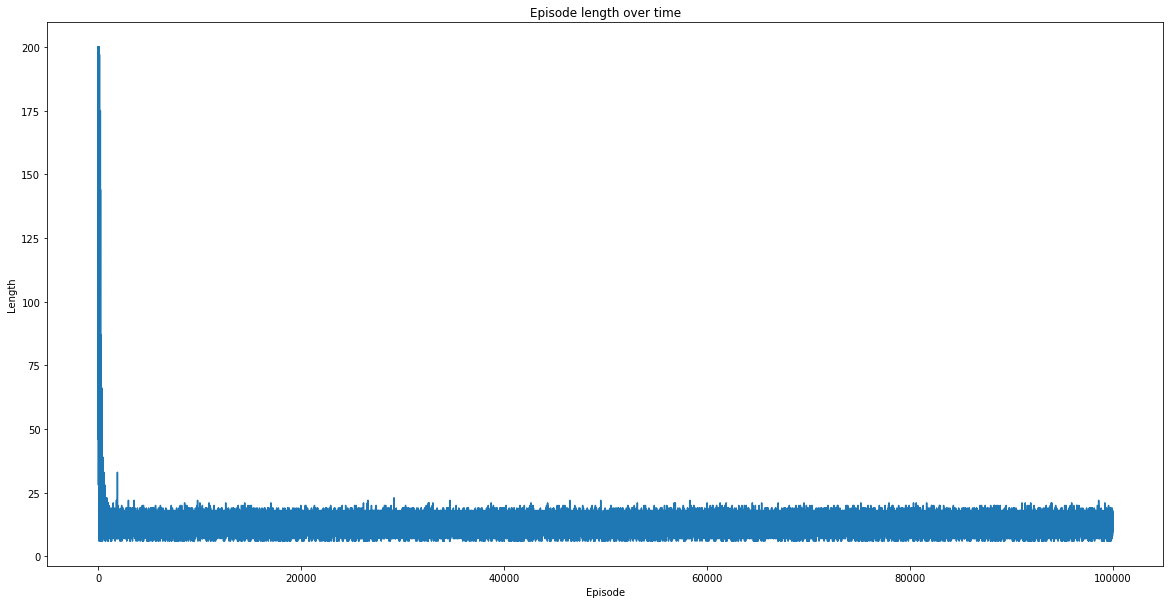

In [400]:
plt.figure(figsize=(20,10))
plt.plot(length_episode_Q)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

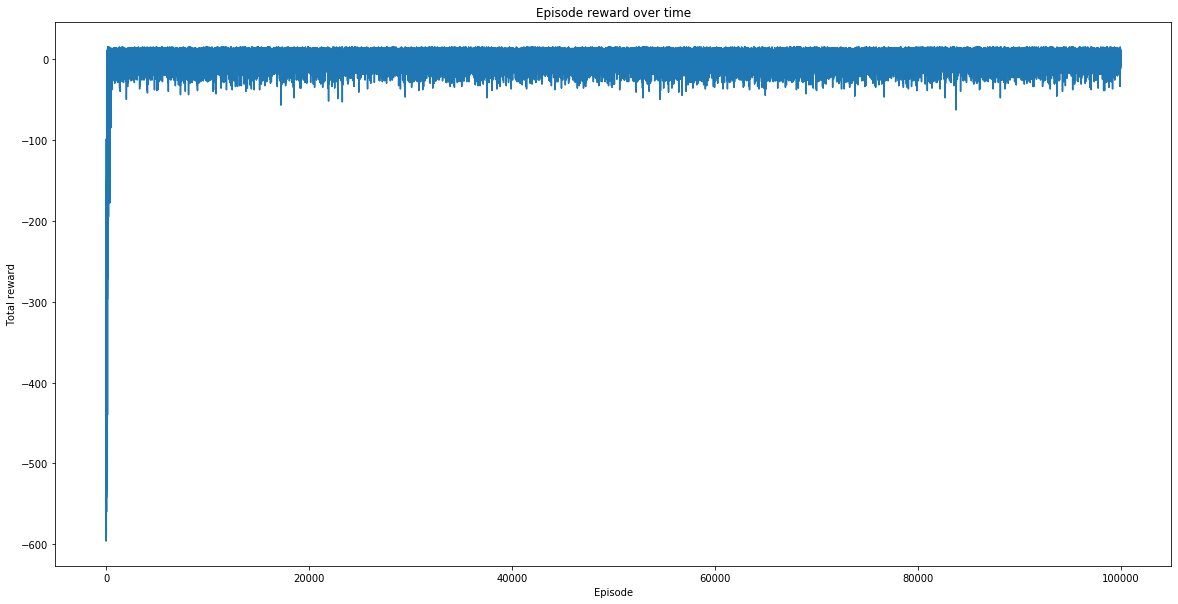

In [412]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_Q)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

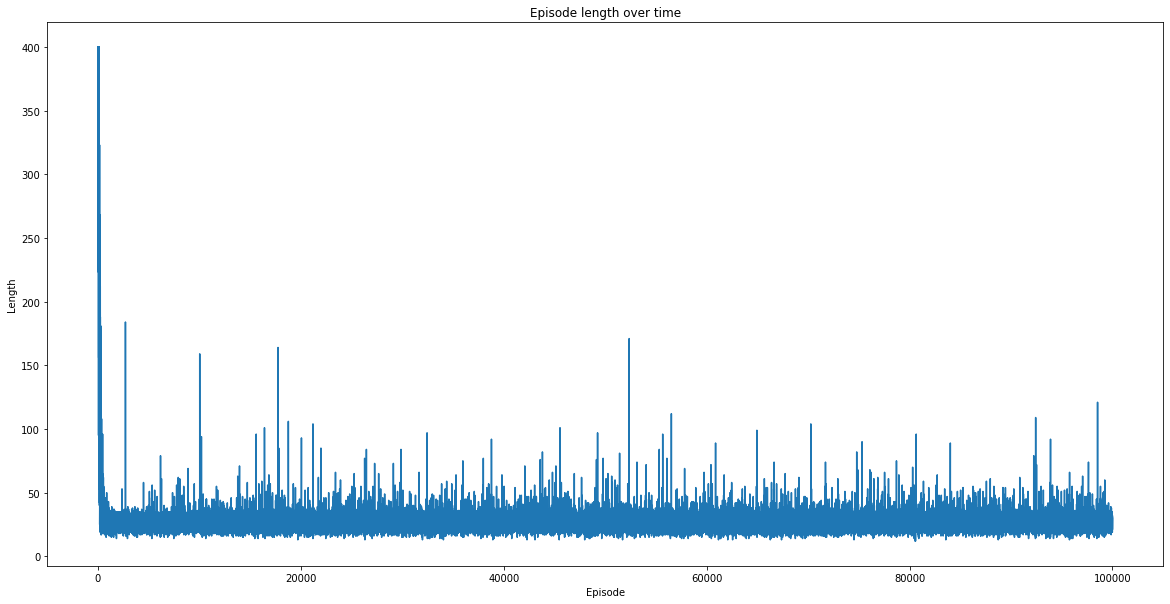

In [410]:
plt.figure(figsize=(20,10))
plt.plot(length_episode_SARSA)
#plt.plot(length_episode_Q)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()

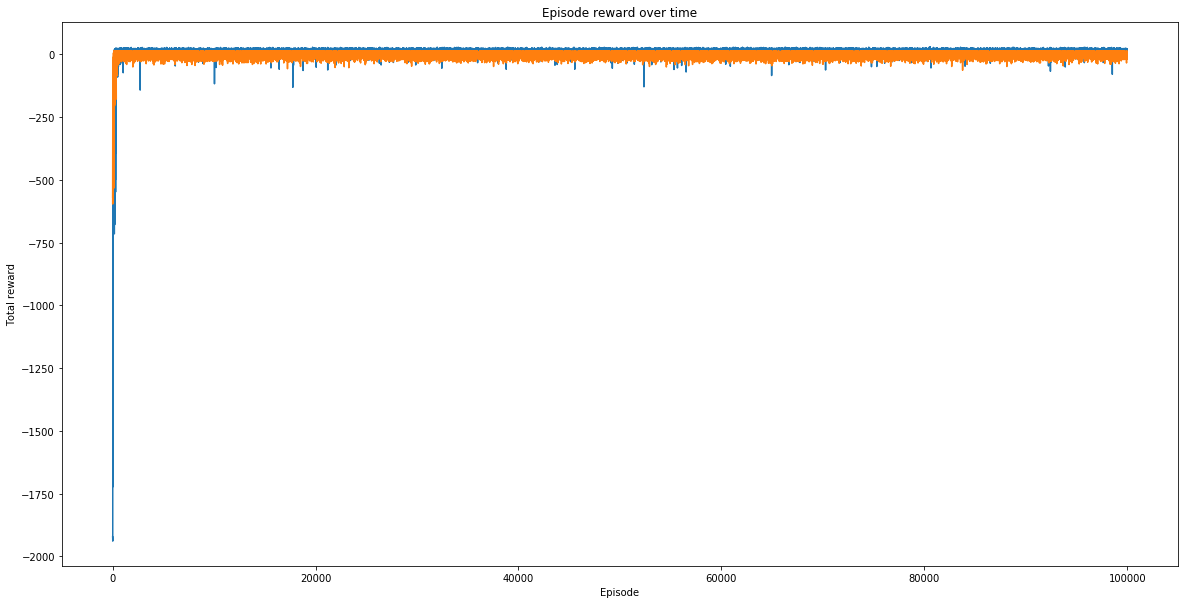

In [414]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_SARSA)
plt.plot(total_reward_episode_Q)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

**TEST BED - (Q Leraning)**



In [372]:
"""Evaluate agent's performance after Q-learning"""



total_epochs_Q = 0
n_episodes = 100
length_episode_Q = [0] * n_episodes
total_reward_episode_Q = [0] * n_episodes
total_penalties_Q = [0] *n_episodes

frames = []

for episode in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        })

        if reward == -10:
            penalties += 10
        elif reward == -1:
            penalties += 1

        epochs += 1

    total_penalties_Q[episode] += penalties
    length_episode_Q[episode] += 1
    total_reward_episode_Q[episode] += reward
    total_epochs_Q += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs_Q / episodes}")
print(f"Average penalties per episode: {sum(total_penalties_Q) / episodes}")
print(f"Average rewards per episode: {sum(total_reward_episode_Q) / episode}")

Results after 100 episodes:
Average timesteps per episode: 13.15
Average penalties per episode: 12.15
Average rewards per episode: 20.2020202020202


In [365]:
print_frames(frames)

+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Timestep: 25
State: 116
Action: 1
Reward: -1


KeyboardInterrupt: ignored

**TEST BED - (SARSA)**

In [382]:
"""Evaluate agent's performance after SARSA"""

total_epochs_SARSA = 0
n_episodes = 100
length_episode_SARSA = [0] * n_episodes
total_reward_episode_SARSA = [0] * n_episodes
total_penalties_SARSA =[0] * n_episodes


frames = []

for episode in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = torch.argmax(optimal_Q[state]).item()
        state, reward, done, info = env.step(action)

        frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        })

        if reward == -10:
            penalties += 10
        elif reward == -1:
            penalties += 1


        epochs += 1

    total_penalties_SARSA[episode] += penalties
    length_episode_SARSA[episode] += 1
    total_reward_episode_SARSA[episode] += reward
    total_epochs_SARSA += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs_SARSA / episodes}")
print(f"Average penalties per episode: {sum(total_penalties_SARSA) / episodes}")
print(f"Average rewards per episode: {sum(total_reward_episode_SARSA) / episode}")

Results after 100 episodes:
Average timesteps per episode: 13.17
Average penalties per episode: 12.17
Average rewards per episode: 20.2020202020202


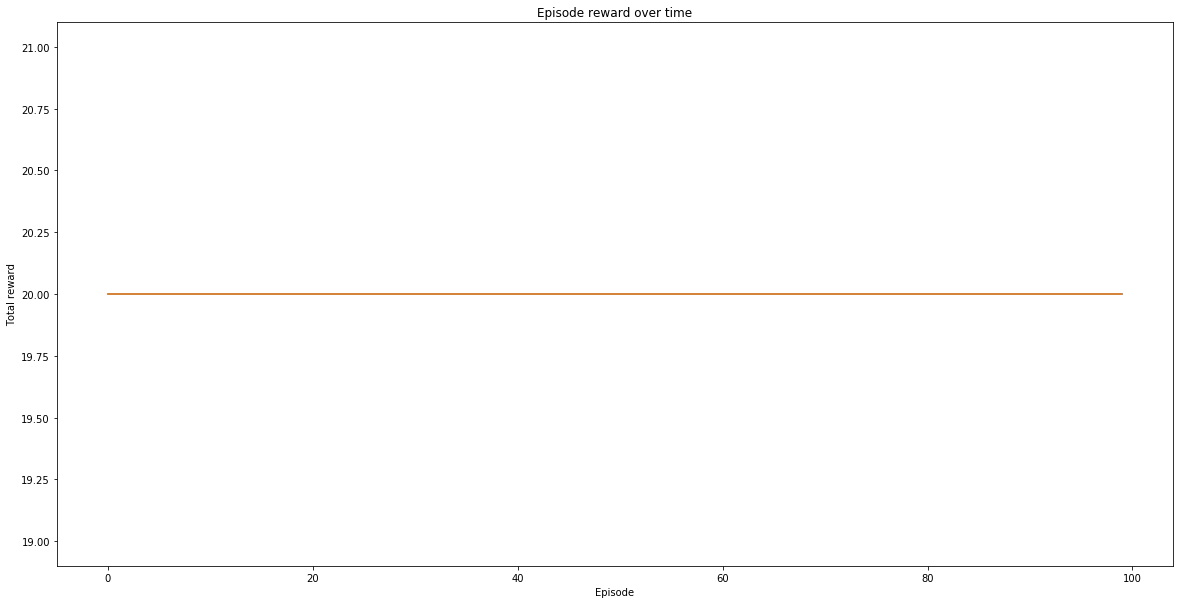

In [383]:
plt.figure(figsize=(20,10))
plt.plot(total_reward_episode_SARSA)
plt.plot(total_reward_episode_Q)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

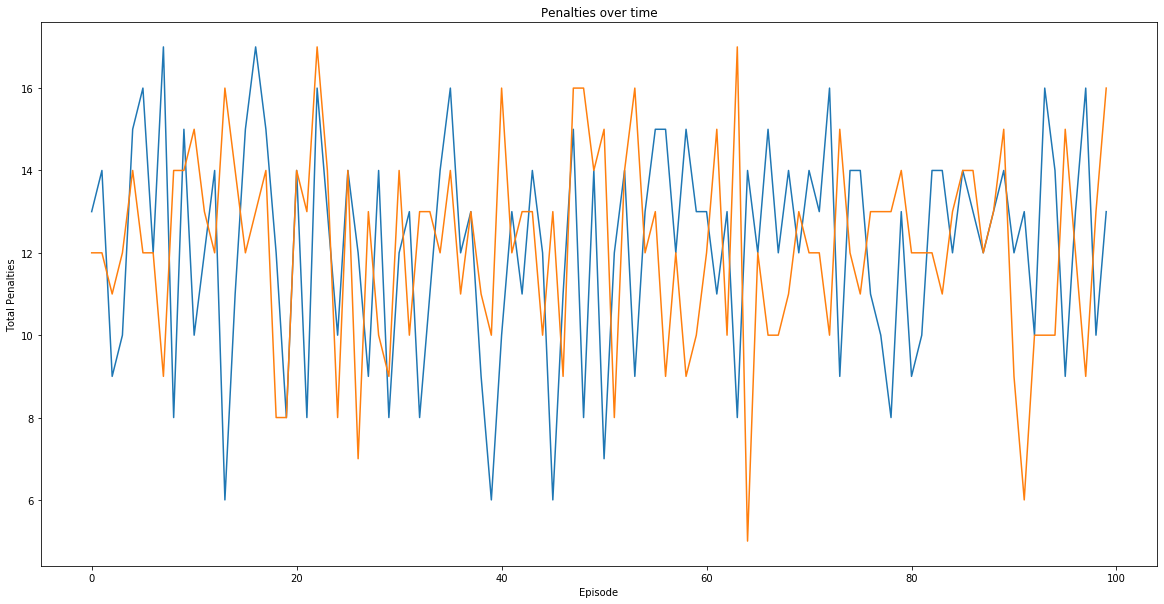

In [384]:
plt.figure(figsize=(20,10))
plt.plot(total_penalties_SARSA)
plt.plot(total_penalties_Q)
plt.title('Penalties over time')
plt.xlabel('Episode')
plt.ylabel('Total Penalties')
plt.show()

In [0]:
print_frames

In [217]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

n_episode = 100000
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs_SARSA = []
all_penalties_SARSA = []
length_episode_SARSA = [0] * n_episode
total_reward_episode_SARSA = [0] * n_episode

for episode in range(n_episode):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False

    if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
    else:
            action = np.argmax(q_table[state]) # Exploit learned value
    
    while not done:
        
        

        next_state, reward, done, info  = env.step(action)

        if random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample() # Explore action space
        else:
            next_action = np.argmax(q_table[next_state]) # Exploit learned value
                                   
             
        td_delta = reward + gamma * q_table[next_state][next_action] - q_table[state][action]
                                                
        q_table[state][action] += alpha * td_delta

        if reward == -10:
            penalties += 1     
        
        state = next_state
        action = next_action

        length_episode[episode] += 1
        total_reward_episode[episode] += reward
        epochs += 1
             
            
    
        
    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode}")


Episode: 99900
CPU times: user 2min 40s, sys: 7.3 s, total: 2min 47s
Wall time: 2min 39s
